<a href="https://colab.research.google.com/github/Mani512996/Data-Science-project/blob/main/Mainprojectfile1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install plotly
!pip install chart_studio
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sklearn
import seaborn as sns
from keras.models import Sequential
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode
import plotly.express as px
from plotly.subplots  import make_subplots
import chart_studio.plotly as py
from chart_studio.plotly import iplot
import plotly.graph_objects as go
from plotly.offline import iplot
from keras import optimizers
from datetime import date
import datetime as dt
from datetime import date

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
START = "2021-01-01"
TODAY = dt.datetime.now().strftime("%Y-%m-%d")




In [ ]:
stock_symbol = 'ITC.NS'
df = yf.download(tickers=stock_symbol,period='5y',interval='1d')


[*********************100%***********************]  1 of 1 completed


In [ ]:
data = df.dropna()

In [ ]:
len(data)


1237

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2017-07-27 to 2022-07-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1237 non-null   float64
 1   High       1237 non-null   float64
 2   Low        1237 non-null   float64
 3   Close      1237 non-null   float64
 4   Adj Close  1237 non-null   float64
 5   Volume     1237 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 67.6 KB


In [ ]:
data.describe

<bound method NDFrame.describe of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-07-27  294.700012  295.399994  286.750000  288.549988  239.834595   
2017-07-28  294.299988  294.750000  287.149994  291.549988  242.328094   
2017-07-31  289.500000  290.299988  284.500000  285.250000  237.091736   
2017-08-01  285.299988  288.549988  285.000000  287.850006  239.252777   
2017-08-02  289.799988  289.899994  284.299988  285.450012  237.257980   
...                ...         ...         ...         ...         ...   
2022-07-21  299.000000  302.200012  298.000000  299.549988  299.549988   
2022-07-22  300.000000  302.500000  298.100006  300.549988  300.549988   
2022-07-25  299.000000  302.950012  298.799988  301.100006  301.100006   
2022-07-26  301.000000  303.750000  300.450012  302.450012  302.450012   
2022-07-27  302.850006  305.000000  300.600006  304.149994  304.149994   

   

In [ ]:
cls = data[['Close']]


In [ ]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('Date', 'Close'),
                    row_heights=[0.2,0.7]
                   )

fig.add_trace(go.Candlestick(x= data.index, open=data['Open'], high=data['High'], low = data['Low'], close=data['Close'], name='OHLC'))




In [ ]:
trace1 = go.Scatter(
                    x = data.index,
                    y = data.Close,
                    mode = "lines",
                    name = "Close",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    )

d1 = [trace1]
layout = dict(title = 'Close values',
              xaxis= dict(title= 'Close',ticklen= 5,zeroline= False)
             )
fig = dict(data = d1, layout = layout)
iplot(fig)


In [ ]:
ds = cls.values
ds

array([[288.54998779],
       [291.54998779],
       [285.25      ],
       ...,
       [301.1000061 ],
       [302.45001221],
       [304.1499939 ]])

In [ ]:
#normalizing the data
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
#splittimg the data into training and testing data

train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size


(865, 372)

In [ ]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]


In [ ]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape


((764, 100), (764,))

In [ ]:
X_test.shape, y_test.shape


((271, 100), (271,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 9s 307ms/step - loss: 0.1282 - val_loss: 0.0062
Epoch 2/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0170 - val_loss: 0.0099
Epoch 3/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0112 - val_loss: 0.0066
Epoch 4/100
12/12 [==============================] - 2s 184ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 5/100
12/12 [==============================] - 2s 188ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 6/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/100
12/12 [==============================] - 3s 280ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 8/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/100
12/12 [==============================] - 2s 190ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 10/100
12/12 [==============================] - 2s 184ms/step - loss: 0.0036 - val_lo

In [ ]:
loss = model.history.history['loss']
trace2 = go.Scatter(
                    x = loss,
                    
                    mode = "lines",
                    name = "loss",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)')
                    )


d2 = [trace2]
layout = dict(title = 'loss',
              xaxis= dict(title= 'loss',ticklen= 5,zeroline= False)
             )
fig = dict(data = d2, layout = layout)
iplot(fig)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)
invds = normalizer.inverse_transform(ds_scaled)

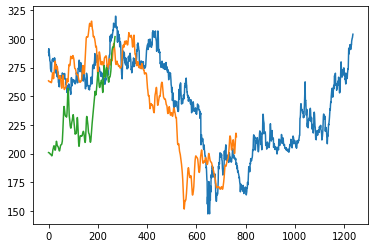

In [ ]:

plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
test = np.vstack((train_predict,test_predict))


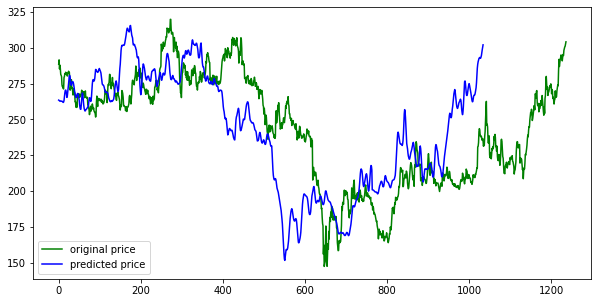

In [ ]:

plt.figure(figsize = (10,5))

plt.plot(normalizer.inverse_transform(ds_scaled), 'g', label = 'original price')
plt.plot((test), 'b', label = 'predicted price')

plt.legend()

plt.show()

In [ ]:
len(ds_test)


372

In [ ]:
fut_inp = ds_test[272:]


In [ ]:
fut_inp = fut_inp.reshape(1,-1)


In [ ]:
tmp_inp = list(fut_inp)


In [ ]:
fut_inp.shape


(1, 100)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 10 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

    
print(lst_output)

[[0.9083868861198425], [0.9119812846183777], [0.9140174388885498], [0.9149636626243591], [0.9151343703269958], [0.9147198796272278], [0.9138458371162415], [0.912605881690979], [0.9110689759254456], [0.9092810153961182]]


In [ ]:
scale=sklearn.preprocessing.MinMaxScaler()

len(ds_scaled)

1237

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,111)

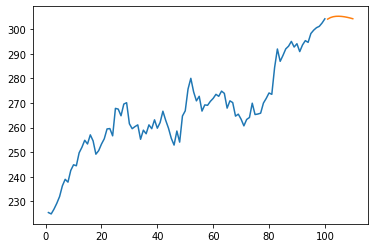

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1137:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()


In [ ]:
len(ds_new)


1237

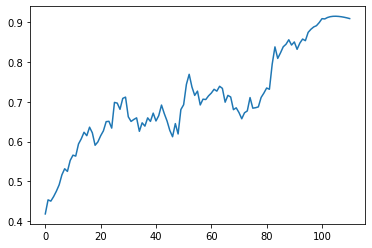

In [ ]:
ds_new.extend(lst_output)
plt.plot(ds_new[1136:])

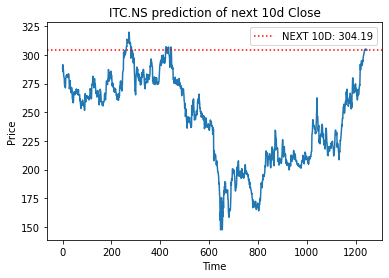

In [ ]:
final_graph = normalizer.inverse_transform(ds_new).tolist()
#Plotting final results with predicted value after 10 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 10d Close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 10D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [ ]:
forecast = normalizer.inverse_transform(lst_output)
print(forecast)

[[304.03758209]
 [304.65797529]
 [305.00941553]
 [305.17273375]
 [305.2021979 ]
 [305.13065681]
 [304.97979706]
 [304.76578075]
 [304.50051081]
 [304.19190881]]


In [ ]:
model.save('Keras.h8')

INFO:tensorflow:Assets written to: Keras.h8/assets


INFO:tensorflow:Assets written to: Keras.h8/assets
